# House Prices Prediction using Advanced Regression Techniques

In this project, I will use Ames housing prices dataset available at **Kaggle**, and apply advanced regression techniques and compare their effectiveness on such problems.

In [35]:
# load packages
import pandas as pd # data frames
import numpy as np # arrays and computing
import seaborn as sns # statistical data visualization
import matplotlib

import matplotlib.pyplot as plt # plots

%matplotlib inline

In [36]:
# load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.shape

(1460, 81)

In [37]:
#check the data
train.columns
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [38]:
#descriptive statistics summary
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


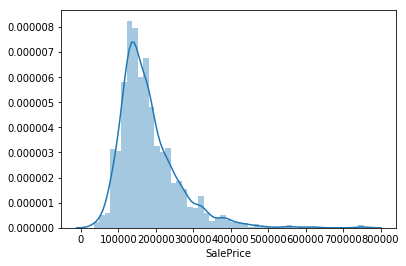

In [39]:
#histogram
sns.distplot(train['SalePrice']);

## Some observations from the histogram:
1. Not a normal distribution
2. Left-skewed distribution
3. Has a clear peak

In [40]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

In [41]:
all_data = pd.get_dummies(all_data)
all_data.shape

(2919, 288)

In [42]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [43]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = np.log1p(train.SalePrice)

In [44]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, LinearRegression, ElasticNetCV
from sklearn.model_selection import cross_val_score
import xgboost as xgb

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [45]:
model_ridge = Ridge()

In [46]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0,0.5,'rmse')

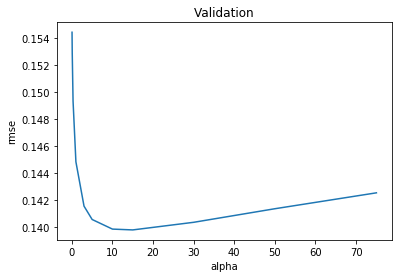

In [47]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [48]:
cv_ridge.min()

0.13976596285220735

In [49]:
# train model
model_ridge = Ridge(alpha=10).fit(X_train, y)
rmse_ridge = rmse_cv(model_ridge).mean()
rmse_ridge

0.13982664627139293

In [50]:
# Linear regression
model_LinearRegr = LinearRegression()
model_LinearRegr.fit(X_train, y)
rmse_LinearRegr = rmse_cv(model_LinearRegr).mean()
rmse_LinearRegr

0.1571208776535738

In [51]:
# RidgeCV
model_RidgeCV = RidgeCV()
model_RidgeCV.fit(X_train, y)
rmse_RidgeCV = rmse_cv(model_RidgeCV).mean()
rmse_RidgeCV

0.1398266753895153

In [52]:
# ElasticNetCV 
model_EN = ElasticNetCV()
model_EN.fit(X_train, y)
rmse_EN = rmse_cv(model_EN).mean()
rmse_EN

0.19829552662829658

In [53]:
# LassoCV 
model_LassoCV= LassoCV()
model_LassoCV.fit(X_train, y)
rmse_LassoCV = rmse_cv(model_LassoCV).mean()
rmse_LassoCV

0.1982720441517538

In [54]:
# xgboost
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

In [55]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=360,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [56]:
rmse_xgb = model.values[-1,0]
rmse_xgb

0.06289133333333334

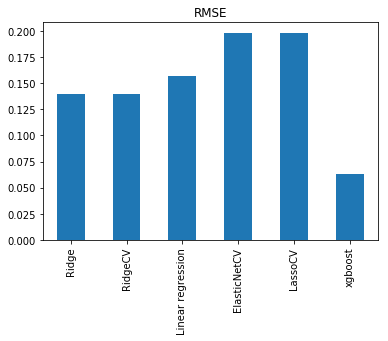

In [57]:
rmse_dict = {'data':[rmse_ridge, rmse_RidgeCV, rmse_LinearRegr, rmse_EN,rmse_LassoCV,rmse_xgb]}
rmse_df = pd.DataFrame(data = rmse_dict, index = ['Ridge','RidgeCV','Linear regression','ElasticNetCV','LassoCV','xgboost'])
rmse_df.plot.bar(legend = False, title = 'RMSE')

In [58]:
# predict
ridge_preds = model_ridge.predict(X_test)

In [59]:
# prepare data for submission
# solution = pd.DataFrame({"id":test.Id, "SalePrice":ridge_preds})
solution = pd.DataFrame({"id":test.Id})
solution = solution.assign(SalePrice = ridge_preds)
solution.head()

,id,SalePrice
0,1461,11.641908
1,1462,11.914709
2,1463,12.051385
3,1464,12.183015
4,1465,12.192227


In [60]:
# save file
solution.to_csv("xgboost_pred.csv", index = False)

# So xgBoost is definitely a great algorithm for this kind of prediction.

but it can sometimes result in overfitted models.